# Loading the Spikes
This notebook shows all the different ways how you can load spikes from the recording and gives some ideas how to build analysis on the spiketrain dataframe.

In [1]:
from polarspike import Overview, stimulus_spikes, spiketrains, stimulus_trace, recording_overview
import polars as pl

# The general structure.
The idea behind the organization of spikes in Polarspike is that spikes are saved on the NAS disk in a polars dataframe and only a subset of spikes necessary for the analysis is loaded into memory. 
The spikes are saved in a file called "alldata.parquet" in the recording folder. Lets have a look at a example recording. This recording is stored in "B:\Marvin\Zebrafish_04_23_2024\Phase_01". The spikes are saved in the same folder, we could access them using polars directly.


In [2]:
spikes_on_disk = pl.scan_parquet(r"B:\Marvin\Zebrafish_04_23_2024\Phase_01\alldata.parquet")
spikes_on_disk

<LazyFrame [2 cols, {"cell_index": Int64, "times": Int64}] at 0x22C3E2A6DD0>

The pl.scan_parquet method allows to check the data <b>without</b> loading it into memory. This is very useful to check if the data is present and to check the columns. If we had loaded the whole table into memory, and this was a huge dataframe, we might run into memory issues already.

In [3]:
spikes_on_disk.columns

['cell_index', 'times']

As we can see above, the dataframe contains the columns "cell_index" and "times". The cell_index colum indicates the cell_index and the times column the frame at which a spike was recorded. Lets look at the first 5 rows. In polars, we can use the collect method to load a subset of data into memory, without loading the whole dataframe. 

In [4]:
spikes_on_disk.head(5).collect()

cell_index,times
i64,i64
0,36468
0,112356
0,113530
0,117587
0,128458


We can feed the dataframe into recording_overview plots to get a quick overview of the spikes. The plotting is done by streaming the data from the disk, so at no time do we require to load the whole dataframe into memory. Since the spikes on the disk are saved in frames, rather than seconds, we need to provide the sampling frequency of the recording, which we need to know.

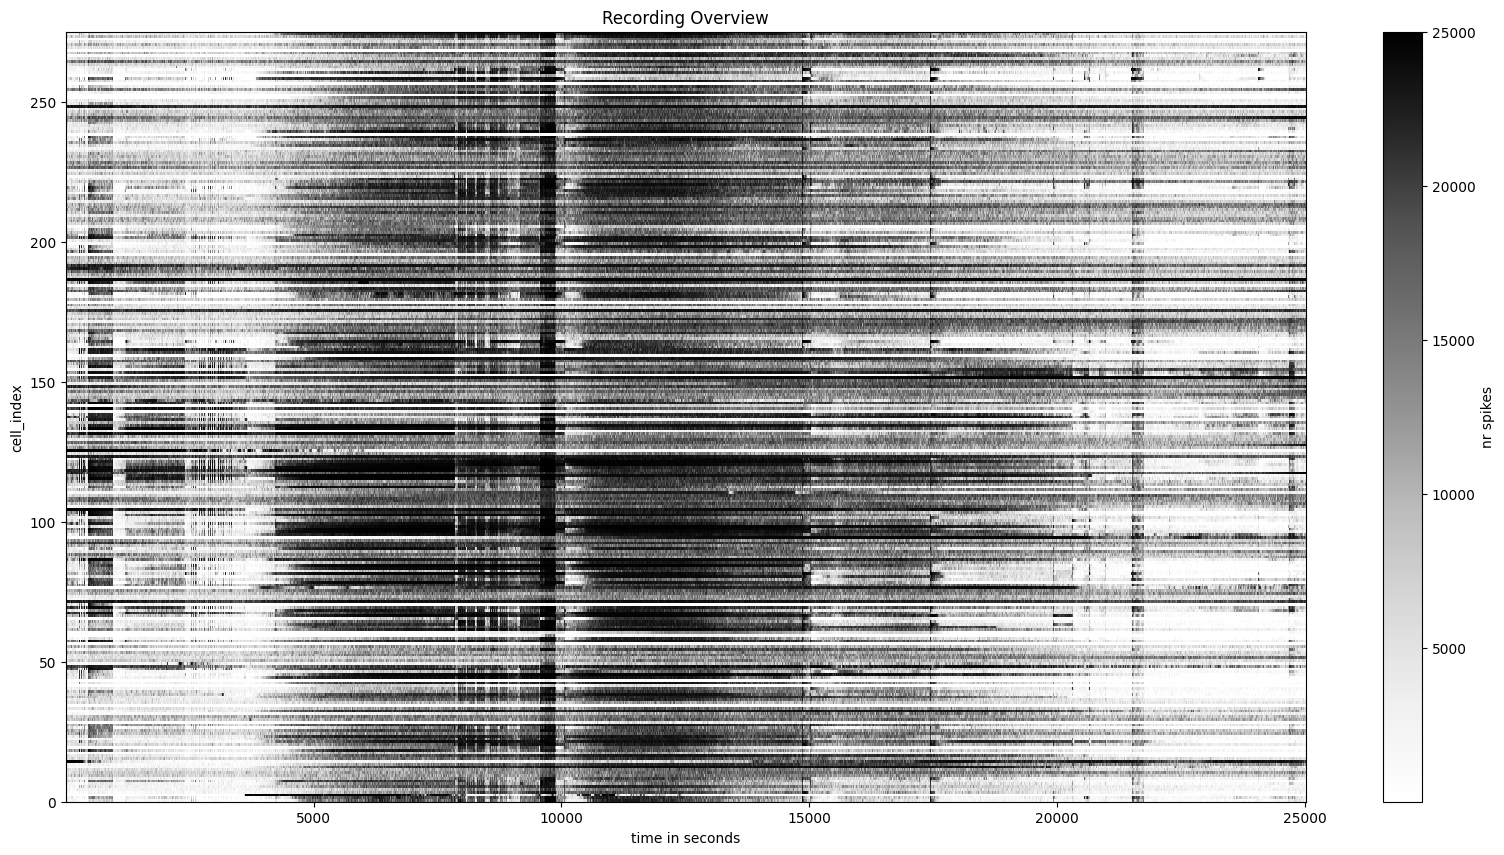

In [5]:
fig, ax = recording_overview.spiketrains_from_file(r"B:\Marvin\Zebrafish_04_23_2024\Phase_01\alldata.parquet", freq=20000)

This figure should look familiar to you from the user interface. It simply reads all spikes from the dataframe and represents the combined spiketrains of all cells as heatmap. 

# Recording object
In most cases, we will have used the GUI to create an "overview" file in the recording folder. We can access the parquet file (the spikes in the dataframe on disk) directly from the recording object:

In [6]:
recording = Overview.Recording.load(r"B:\Marvin\Zebrafish_04_23_2024\Phase_01\overview")
recording.parquet_path

'B:\\Marvin\\Zebrafish_04_23_2024\\Phase_01\\alldata.parquet'

So the graph we created above can be created more easily by using the recording object. This also allows us to access the sampling frequency of the recording.

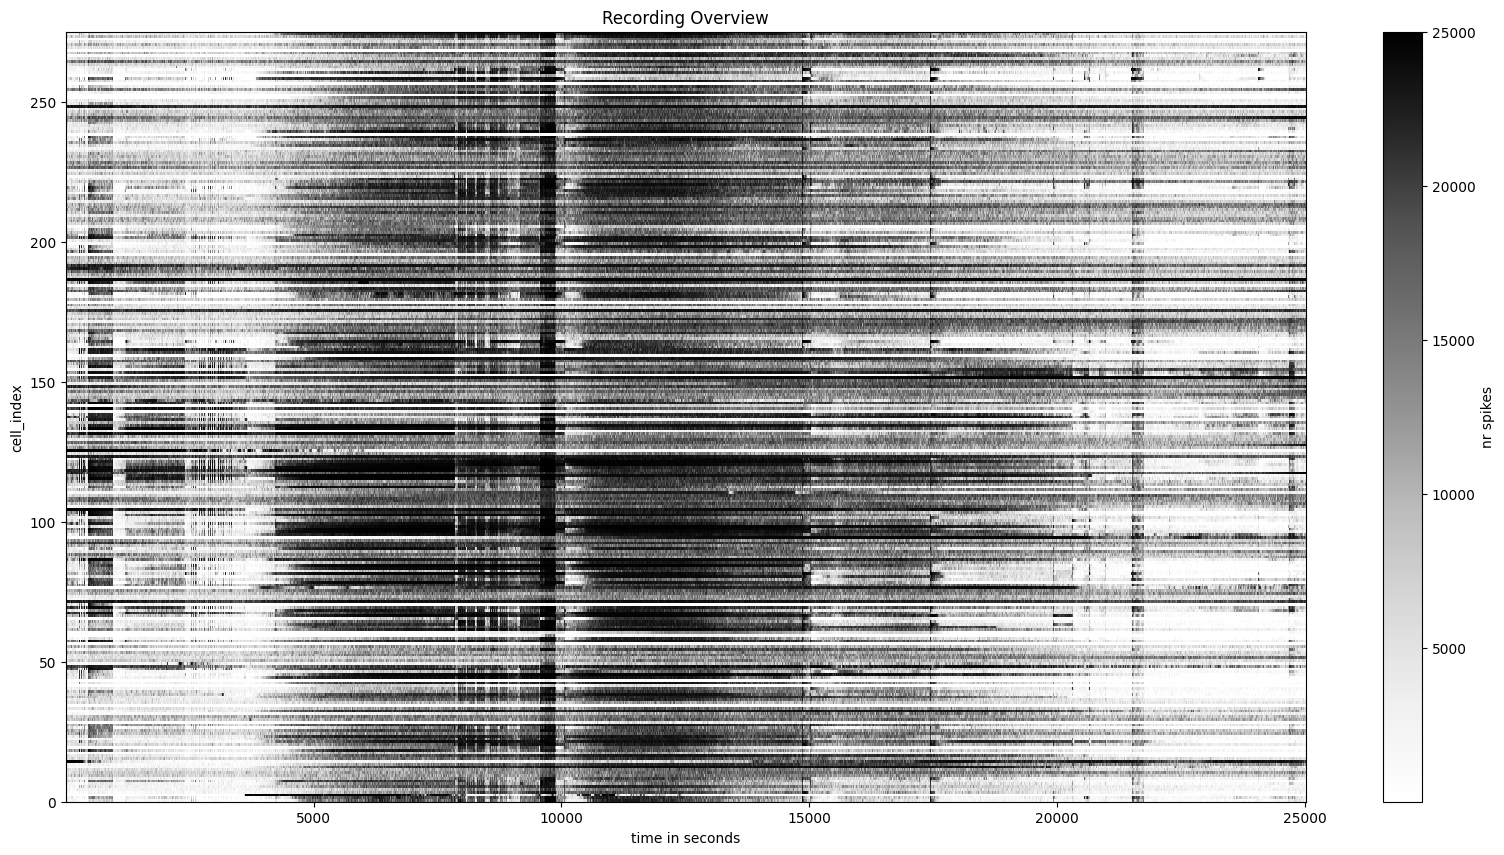

In [7]:
fig, ax = recording_overview.spiketrains_from_file(recording.parquet_path, freq=recording.sampling_freq)

## Loading subsets of spikes
In most cases, we want to analyze only a subset of spikes. For example, we might only be interested in the spikes that were recorded 
during a specific stimulus presentation. In this case, we can load only the spikes that are relevant for the analysis using methods of the recording object.
In those cases, the recording object will scan the .parquet file, search for the spikes that fall within the time of the stimulus presentation and load only those spikes into memory. 

The most straightforward and most explicit way to load the spikes is to use the "get_spikes_triggered" function.
```python
def get_spikes_triggered(  # Function works on single recording only
        stimuli,
        cells,
        time="seconds",
        waveforms=False,
        pandas=True,
        stimulus_df="stimulus_df",
        cell_df="spikes_df",
        carry=None,
    )
```
The stimuli and cells parameter can be provided as list of lists:
Lets look at some examples to make the idea clear.

In [8]:
# Load one stimulus and one cell
recording.get_spikes_triggered([[0]], [[0]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,5.61780,0.36380,0,0,0.36380,0
1,0,5.67650,0.42250,0,0,0.42250,0
2,0,5.87935,0.62535,0,0,0.62535,0
3,0,6.42290,1.16890,0,0,1.16890,0
4,0,9.31020,4.05620,1,0,4.05620,0
...,...,...,...,...,...,...,...
151,0,235.44205,230.18805,3,9,14.08330,0
152,0,236.31705,231.06305,3,9,14.95830,0
153,0,237.48050,232.22650,4,9,16.12175,0
154,0,238.37430,233.12030,4,9,17.01555,0


In [9]:
# Load one stimulus and two cells:
recording.get_spikes_triggered([[0]], [[0, 1]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,5.61780,0.36380,0,0,0.36380,0
1,0,5.67650,0.42250,0,0,0.42250,0
2,0,5.87935,0.62535,0,0,0.62535,0
3,0,6.42290,1.16890,0,0,1.16890,0
4,1,5.40840,0.15440,0,0,0.15440,0
...,...,...,...,...,...,...,...
341,1,237.57955,232.32555,4,9,16.22080,0
342,1,238.32790,233.07390,4,9,16.96915,0
343,1,241.00430,235.75030,4,9,19.64555,0
344,0,241.64640,236.39240,5,9,20.28765,0


In [10]:
# Load two stimuli and one cell:
recording.get_spikes_triggered([[0], [1]], [[0]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,5.61780,0.36380,0,0,0.36380,0
1,0,5.67650,0.42250,0,0,0.42250,0
2,0,5.87935,0.62535,0,0,0.62535,0
3,0,6.42290,1.16890,0,0,1.16890,0
4,0,9.31020,4.05620,1,0,4.05620,0
...,...,...,...,...,...,...,...
181,0,377.38325,115.25865,1,3,6.13435,1
182,0,378.48860,116.36400,1,3,7.23970,1
183,0,380.68380,118.55920,1,3,9.43490,1
184,0,386.91275,124.78815,1,3,15.66385,1


In [11]:
# Load two stimuli and two cells:
recording.get_spikes_triggered([[0], [1]], [[0, 1], [0, 1]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,5.61780,0.36380,0,0,0.36380,0
1,0,5.67650,0.42250,0,0,0.42250,0
2,0,5.87935,0.62535,0,0,0.62535,0
3,0,6.42290,1.16890,0,0,1.16890,0
4,1,5.40840,0.15440,0,0,0.15440,0
...,...,...,...,...,...,...,...
460,1,381.30350,119.17890,1,3,10.05460,1
461,1,381.62665,119.50205,1,3,10.37775,1
462,1,381.66320,119.53860,1,3,10.41430,1
463,1,397.70755,135.58295,1,3,26.45865,1


In [12]:
# Load one stimulus and all cells:
recording.get_spikes_triggered([[0]], [["all"]])

,cell_index,times,times_relative,trigger,repeat,times_triggered,stimulus_index
0,0,5.61780,0.36380,0,0,0.36380,0
1,0,5.67650,0.42250,0,0,0.42250,0
2,0,5.87935,0.62535,0,0,0.62535,0
3,0,6.42290,1.16890,0,0,1.16890,0
4,1,5.40840,0.15440,0,0,0.15440,0
...,...,...,...,...,...,...,...
202948,273,243.75555,238.50155,5,9,22.39680,0
202949,273,243.77640,238.52240,5,9,22.41765,0
202950,273,244.61030,239.35630,5,9,23.25155,0
202951,273,244.94010,239.68610,5,9,23.58135,0


## Load as numpy:
Spikes can be loaded directly as numpy arrays. In this case, you can only load a single stimulus at a time to keep the output structured.

In [13]:
# Load a single cell
cells, spikes = recording.get_spikes_as_numpy([[0]], [[0]])
spikes

array([array([ 0.3638 ,  0.4225 ,  0.62535,  1.1689 ,  4.0562 ,  4.1859 ,
               4.1977 ,  4.2243 ,  4.2697 ,  8.0598 ,  8.1374 ,  8.13885,
               8.14285,  8.15905, 12.07875, 12.08455, 12.11515, 16.11685,
               0.07145,  4.0622 ,  4.1734 ,  4.1756 ,  4.1873 ,  4.1907 ,
               4.2173 ,  6.1061 ,  8.0613 ,  8.12965,  8.1351 ,  8.1401 ,
               8.14815, 12.07915,  0.64775,  2.45585,  4.05755,  4.1877 ,
               4.20475,  4.22115,  5.2575 ,  7.87705,  8.0612 ,  8.1502 ,
               8.22395,  9.6055 , 12.0794 , 12.08475, 17.57125, 20.73585,
              22.7542 ,  4.05755,  4.16775,  4.16895,  4.17325,  4.18175,
               4.18695,  6.7553 ,  8.0618 ,  8.1462 , 12.20905, 16.2352 ,
              19.64975, 21.2389 ,  4.1847 ,  4.19775,  4.2006 ,  5.072  ,
               8.06265,  8.0634 ,  8.07035,  8.13375,  8.1477 ,  8.14945,
              12.18905, 12.43385, 14.262  , 16.25465, 17.2361 , 18.1775 ,
              19.6945 ,  0.07055,  0.0

In [14]:
# Load multiple cells
cells, spikes = recording.get_spikes_as_numpy([[0]], [[0, 1, 2]])
spikes

array([array([ 0.3638 ,  0.4225 ,  0.62535,  1.1689 ,  4.0562 ,  4.1859 ,
               4.1977 ,  4.2243 ,  4.2697 ,  8.0598 ,  8.1374 ,  8.13885,
               8.14285,  8.15905, 12.07875, 12.08455, 12.11515, 16.11685,
               0.07145,  4.0622 ,  4.1734 ,  4.1756 ,  4.1873 ,  4.1907 ,
               4.2173 ,  6.1061 ,  8.0613 ,  8.12965,  8.1351 ,  8.1401 ,
               8.14815, 12.07915,  0.64775,  2.45585,  4.05755,  4.1877 ,
               4.20475,  4.22115,  5.2575 ,  7.87705,  8.0612 ,  8.1502 ,
               8.22395,  9.6055 , 12.0794 , 12.08475, 17.57125, 20.73585,
              22.7542 ,  4.05755,  4.16775,  4.16895,  4.17325,  4.18175,
               4.18695,  6.7553 ,  8.0618 ,  8.1462 , 12.20905, 16.2352 ,
              19.64975, 21.2389 ,  4.1847 ,  4.19775,  4.2006 ,  5.072  ,
               8.06265,  8.0634 ,  8.07035,  8.13375,  8.1477 ,  8.14945,
              12.18905, 12.43385, 14.262  , 16.25465, 17.2361 , 18.1775 ,
              19.6945 ,  0.07055,  0.0

# Warning!
Be aware that cells which dont spike at all during a stimulus presentation will not appear in the output. This is because the function only loads the spikes that are present in the dataframe.
You can use the cells variable to check which cells are present in the output. In this case, cell 2 was no present in the output.

In [15]:
cells

array([0, 1], dtype=int64)

# Internal structure
How does the script know which times to load for stimulus 0? The information for this is stored in the spikes_df and stimulus_df in the recording object. 
The spikes_df contains the information about which cells spikes at a given stimulus how many times. The stimulus_df contains the information about the stimulus presentations, including the start and end time of the stimulus and the trigger during the stimulus presentation. When loading spikes using the recording object, both information will be combined to load the correct spikes.

In [16]:
recording.spikes_df

,cell_index,stimulus_index,stimulus_name,nr_of_spikes,centres_x,centres_y,recording,filter,qi
0,0,0,fff,156,100.0,1300.0,zebrafish_04_23_2024_p1,True,0.795561
1,0,1,chirp,30,100.0,1300.0,zebrafish_04_23_2024_p1,True,0.329191
2,0,2,ffnoise,968,100.0,1300.0,zebrafish_04_23_2024_p1,True,NaN
3,0,3,splitty_noise_shuffle_w,720,100.0,1300.0,zebrafish_04_23_2024_p1,True,NaN
4,0,4,chirp610,103,100.0,1300.0,zebrafish_04_23_2024_p1,True,0.585152
...,...,...,...,...,...,...,...,...,...
7999,276,24,1px_10hz_non_shuffle_bb,0,NaN,NaN,zebrafish_04_23_2024_p1,True,NaN
8000,276,25,fff,0,NaN,NaN,zebrafish_04_23_2024_p1,True,0.000000
8001,276,26,big_shuffle_u_b_bb_gg,0,NaN,NaN,zebrafish_04_23_2024_p1,True,NaN
8002,276,27,ffnoise,0,NaN,NaN,zebrafish_04_23_2024_p1,True,NaN


In [17]:
recording.stimulus_df

,stimulus_name,begin_fr,end_fr,trigger_fr_relative,trigger_int,stimulus_index,stimulus_repeat_logic,stimulus_repeat_sublogic,sampling_freq,recording,trigger_ends,nr_repeats
0,fff,105080,4907408,"[0, 80040, 160078, 240117, 320156, 400195, 480...","[80040, 80038, 80039, 80039, 80039, 80039, 800...",0,6,2,20000.0,zebrafish_04_23_2024_p1,"[80038, 160078, 240116, 320156, 400194, 480233...",10
1,chirp,5242492,8152472,"[0, 60223, 727493, 787732, 1454997, 1515221, 2...","[60223, 667270, 60239, 667265, 60224, 667265, ...",1,2,1,20000.0,zebrafish_04_23_2024_p1,"[60223, 727488, 787717, 1454997, 1515220, 2182...",4
2,ffnoise,8964793,18964634,"[0, 994, 1994, 2994, 3994, 4994, 5994, 6994, 7...","[994, 1000, 1000, 1000, 1000, 1000, 1000, 1000...",2,18000,1,20000.0,zebrafish_04_23_2024_p1,"[994, 1994, 2994, 3994, 4994, 5994, 6994, 7994...",0
3,splitty_noise_shuffle_w,23985257,47985163,"[0, 2003, 3999, 6001, 8001, 9999, 11997, 14000...","[2003, 1996, 2002, 2000, 1998, 1998, 2003, 199...",3,12000,1,20000.0,zebrafish_04_23_2024_p1,"[2003, 3999, 6001, 8001, 9999, 11997, 14000, 1...",1
4,chirp610,50499617,53410117,"[0, 60182, 727614, 787811, 1455243, 1515440, 2...","[60182, 667432, 60197, 667432, 60197, 667431, ...",4,2,1,20000.0,zebrafish_04_23_2024_p1,"[60182, 727613, 787811, 1455243, 1515425, 2182...",4
5,chirp560,53642157,56552668,"[0, 60194, 727625, 787822, 1455253, 1515451, 2...","[60194, 667431, 60197, 667431, 60198, 667431, ...",5,2,1,20000.0,zebrafish_04_23_2024_p1,"[60194, 727625, 787822, 1455253, 1515447, 2182...",4
6,chirp535,57421879,60332390,"[0, 60193, 727625, 787822, 1455253, 1515451, 2...","[60193, 667432, 60197, 667431, 60198, 667431, ...",6,2,1,20000.0,zebrafish_04_23_2024_p1,"[60193, 727624, 787822, 1455253, 1515446, 2182...",4
7,chirp460,61270082,64180589,"[0, 60190, 727620, 787819, 1455248, 1515448, 2...","[60190, 667430, 60199, 667429, 60200, 667429, ...",7,2,1,20000.0,zebrafish_04_23_2024_p1,"[60190, 727619, 787819, 1455248, 1515438, 2182...",4
8,chirp413,64394981,67305482,"[0, 60183, 727615, 787812, 1455244, 1515441, 2...","[60183, 667432, 60197, 667432, 60197, 667431, ...",8,2,1,20000.0,zebrafish_04_23_2024_p1,"[60183, 727614, 787812, 1455244, 1515427, 2182...",4
9,chirp365,67466674,70377111,"[0, 60183, 727610, 787791, 1455219, 1515400, 2...","[60183, 667427, 60181, 667428, 60181, 667428, ...",9,2,1,20000.0,zebrafish_04_23_2024_p1,"[60181, 727610, 787791, 1455219, 1515400, 2182...",4


We could load the spikes for stimulus 0 and all cells by hand from the parquet file:
The spikes have to be larger (>) than the begin_fr and smaller (<) than the end_fr of the stimulus presentation.

In [18]:
spikes = pl.scan_parquet(recording.parquet_path)
spikes = spikes.filter((pl.col("times") > recording.stimulus_df.iloc[0]["begin_fr"]) & (pl.col("times") < recording.stimulus_df.iloc[0]["end_fr"])).collect()

In [19]:
spikes

cell_index,times
i64,i64
0,112356
0,113530
0,117587
0,128458
0,186204
0,188798
0,189034
0,189566
0,190474


Now we would have to divide by sampling frequency to get the times in seconds and further align the spikes to individual trigger signals. I will not show this here, but I hope the principle is clear. This will all happen behind the scenes when using the get_spikes_triggered function.

We can use the loaded spikes to create an overview plot:

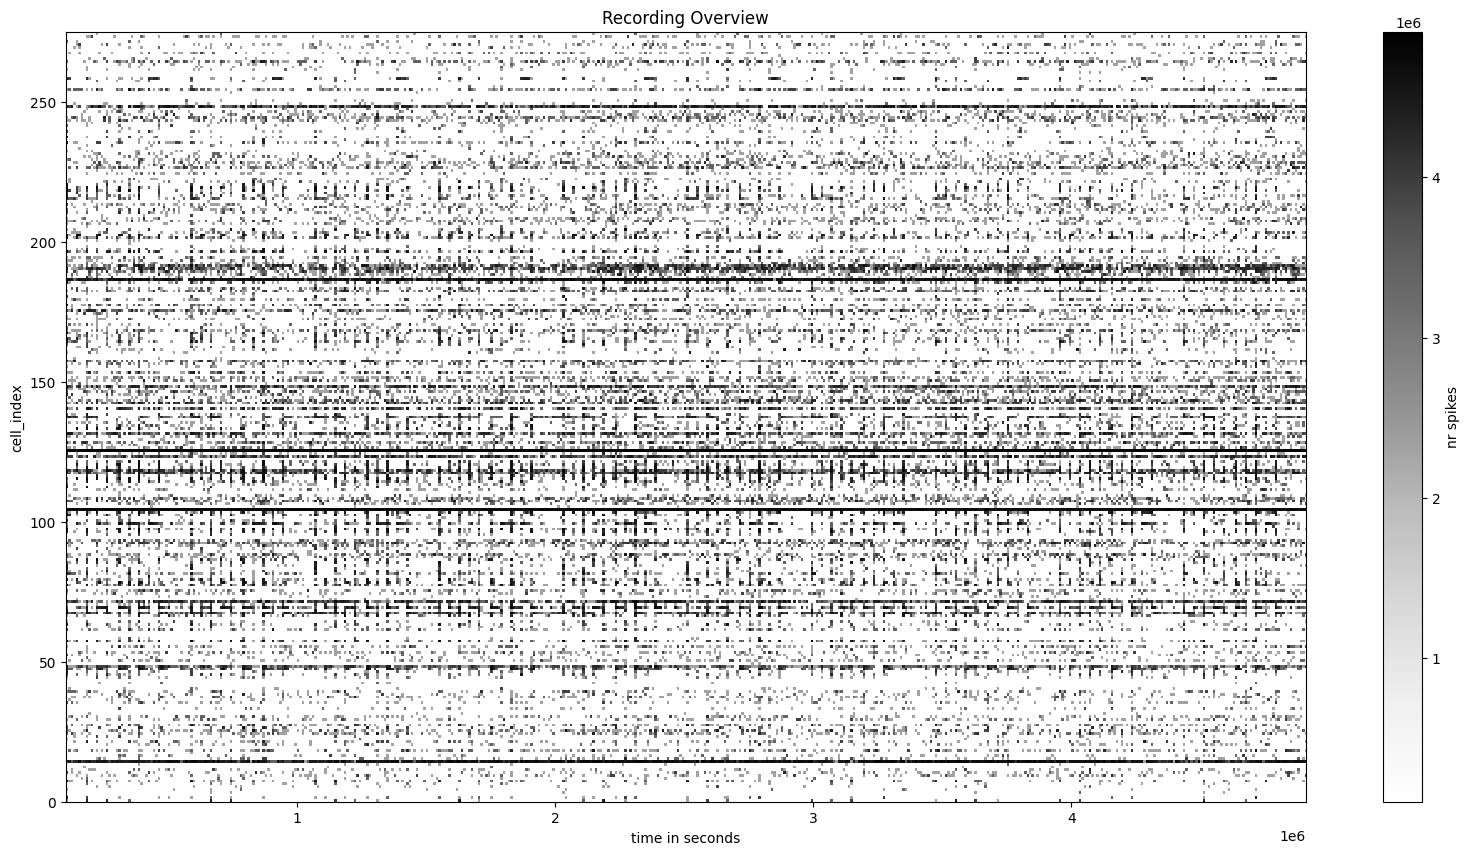

In [20]:
fig, ax = recording_overview.plot_spiketrains(spikes.lazy(), "Greys", width=500)

Please note that the "width" parameter in this plot is the width of the plot in pixel. So, effectively, this is the number of bins in the x-axis.
I will elaborate on the heatmap plotting in the next notebook.
Thank you for reading!